# Generate simulation data

In [1]:
# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde

# Timer
import time as ti
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['figure.constrained_layout.use'] = True

# anndata
import anndata as ad

In [2]:
import sys
import os
import importlib

# Define the path to the monod directory
monod_path = os.path.abspath(os.path.join('..', 'monod', 'src', 'monod'))

# Adjust the system path to include the directory containing the monod package
sys.path.insert(0, monod_path)

import extract_data, cme_toolbox, inference, analysis

# Reload the module
importlib.reload(cme_toolbox)

<module 'cme_toolbox' from '/home/mffang/workspace/Monod/monod/src/monod/cme_toolbox.py'>

In [3]:
import logging
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.DEBUG)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

## Generate parameters

Degradation rates are inspired by Figure 2 by Schwanhausser et al. 2011. Global quantification of mammalian gene expression control

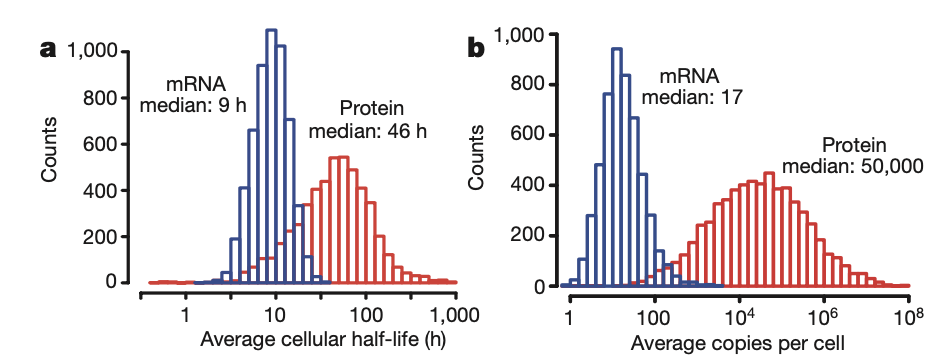

In [4]:
num_genes = 100

# generate paramters; time unit = h
np.random.seed(0)
true_params = np.zeros((num_genes,5))
true_params[:,0] = np.random.lognormal(mean=1.0, sigma=0.5,size=num_genes)
true_params[:,1] = np.random.lognormal(mean=1.0, sigma=0.5,size=num_genes)
true_params[:,2] = np.random.lognormal(mean=0.0, sigma=0.5,size=num_genes)
true_params[:,3] = np.random.lognormal(mean=2.0, sigma=0.5,size=num_genes)
true_params[:,4] = np.random.lognormal(mean=-2.0, sigma=1,size=num_genes)

true_params[0]

array([6.56679686, 6.96972207, 0.83144434, 3.84485763, 0.07437362])

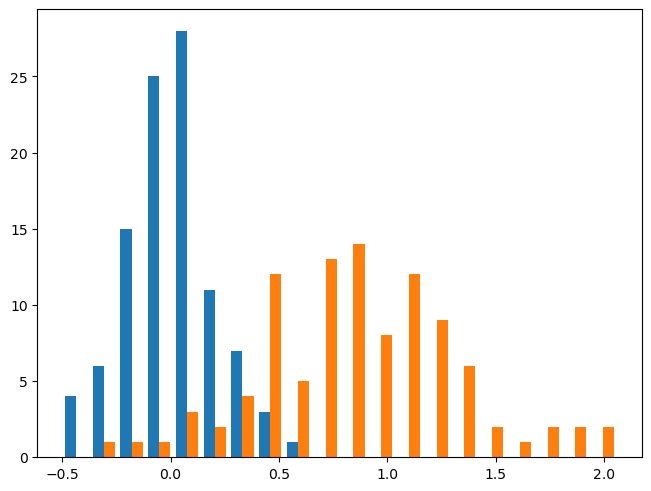

In [5]:
plt.hist([np.log10(1/true_params[:,2]),np.log10(1/true_params[:,4])],bins=20);

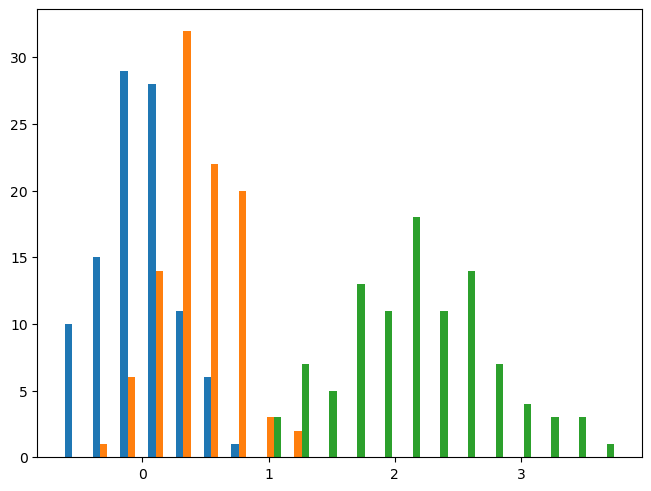

In [6]:
plt.hist([np.log10(true_params[:,0]/true_params[:,1]),np.log10(true_params[:,0]/true_params[:,2]),np.log10(true_params[:,0]/true_params[:,2]*true_params[:,3]/true_params[:,4])],bins=20);

In [7]:
true_params[0]

array([6.56679686, 6.96972207, 0.83144434, 3.84485763, 0.07437362])

## Generate data

In [114]:
num_cells = 10000
num_genes = 100

nascent_data = np.zeros((num_cells, num_genes))  
mature_data = np.zeros((num_cells, num_genes)) 
protein_data = np.zeros((num_cells, num_genes)) 

for j in tqdm(range(num_genes)):
    data = simulate_gene(true_params[j], n=num_cells, timepoints = np.arange(0, 1.1e6, 100))
    nascent_data[:,j] = data[0]
    mature_data[:,j] = data[1]
    protein_data[:,j] = data[2]


00%|██████████| 100/100 [14:00<00:00,  8.40s/it]

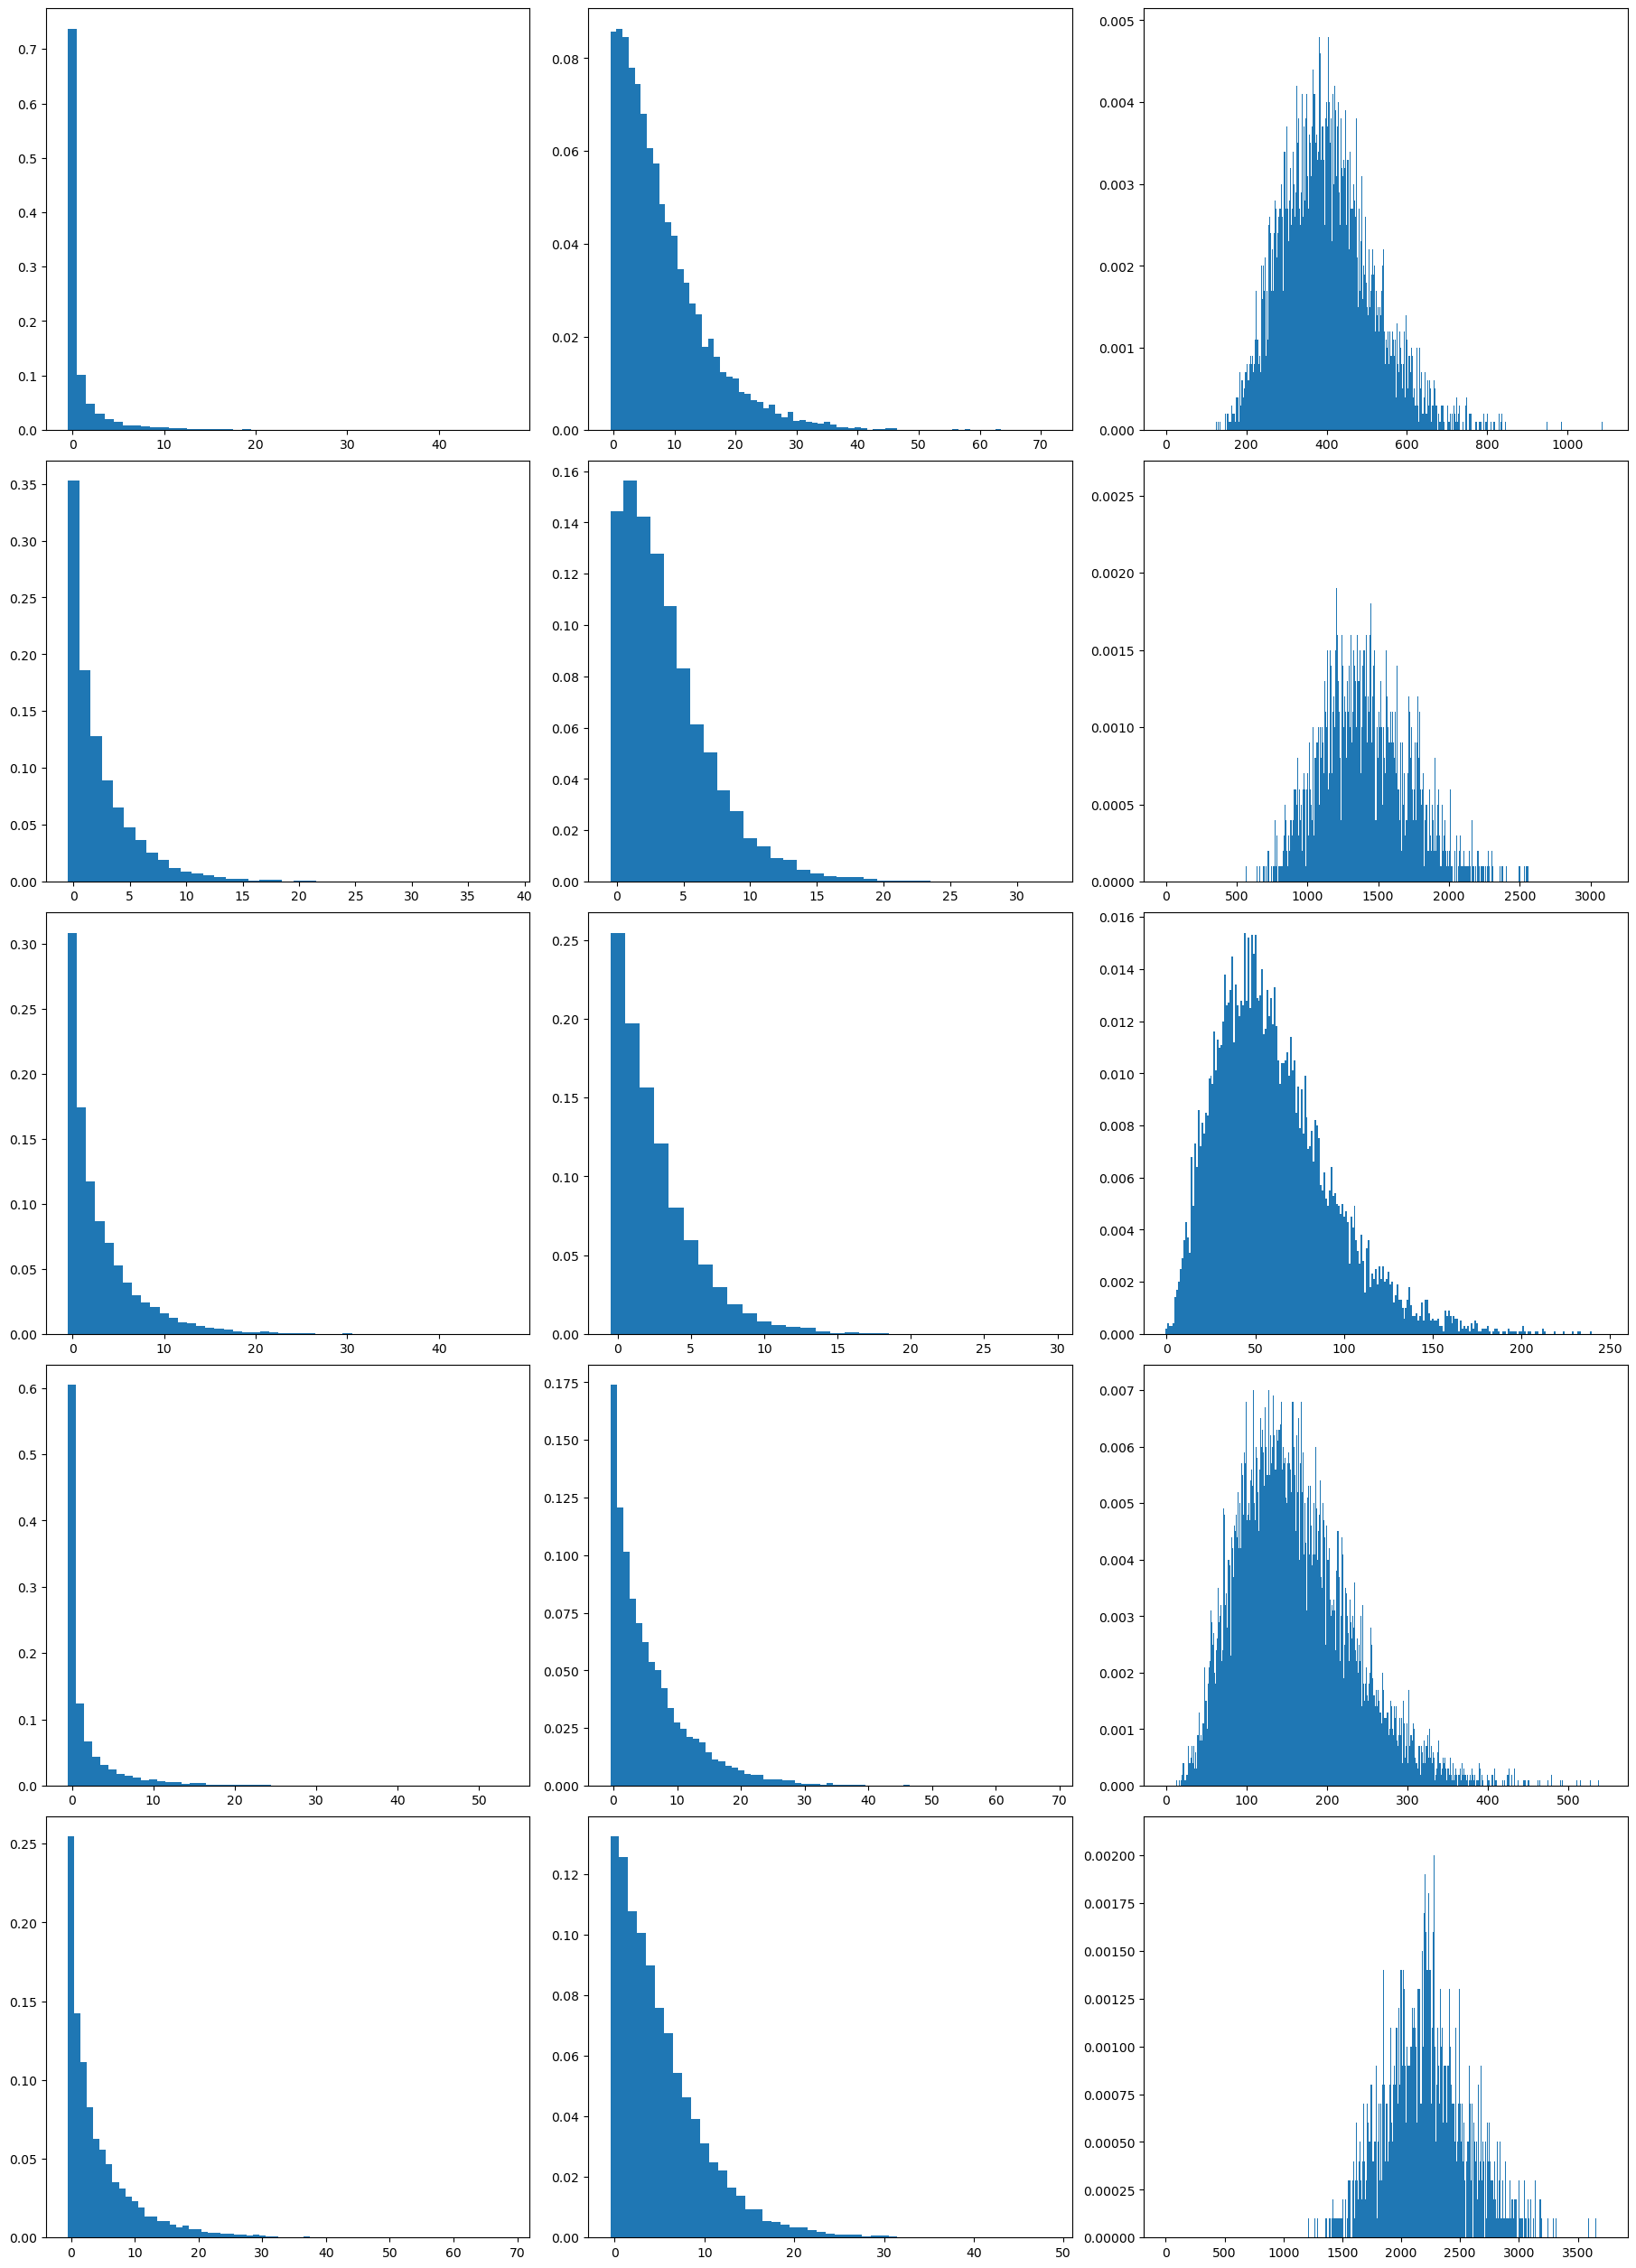

In [115]:
num_gene_plot = 5
fig, ax = plt.subplots(num_gene_plot,3,figsize=(3*6,num_gene_plot*5))

for i in range(num_gene_plot):
    ax[i,0].hist(nascent_data[:,i],bins=np.arange(nascent_data[:,i].max()+10)-0.5,density=True,zorder=0);
    ax[i,1].hist(mature_data[:,i],bins=np.arange(mature_data[:,i].max()+10)-0.5,density=True,zorder=0);
    ax[i,2].hist(protein_data[:,i],bins=np.arange(protein_data[:,i].max()+10)-0.5,density=True,zorder=0);

In [161]:
samp_n, samp_m,samp_p = 0.1,0.1,0.1
nascent_counts = np.random.poisson(lam=samp_n*nascent_data)
mature_counts = np.random.poisson(lam=samp_m*mature_data)
protein_counts = np.random.poisson(lam=samp_p*protein_data)

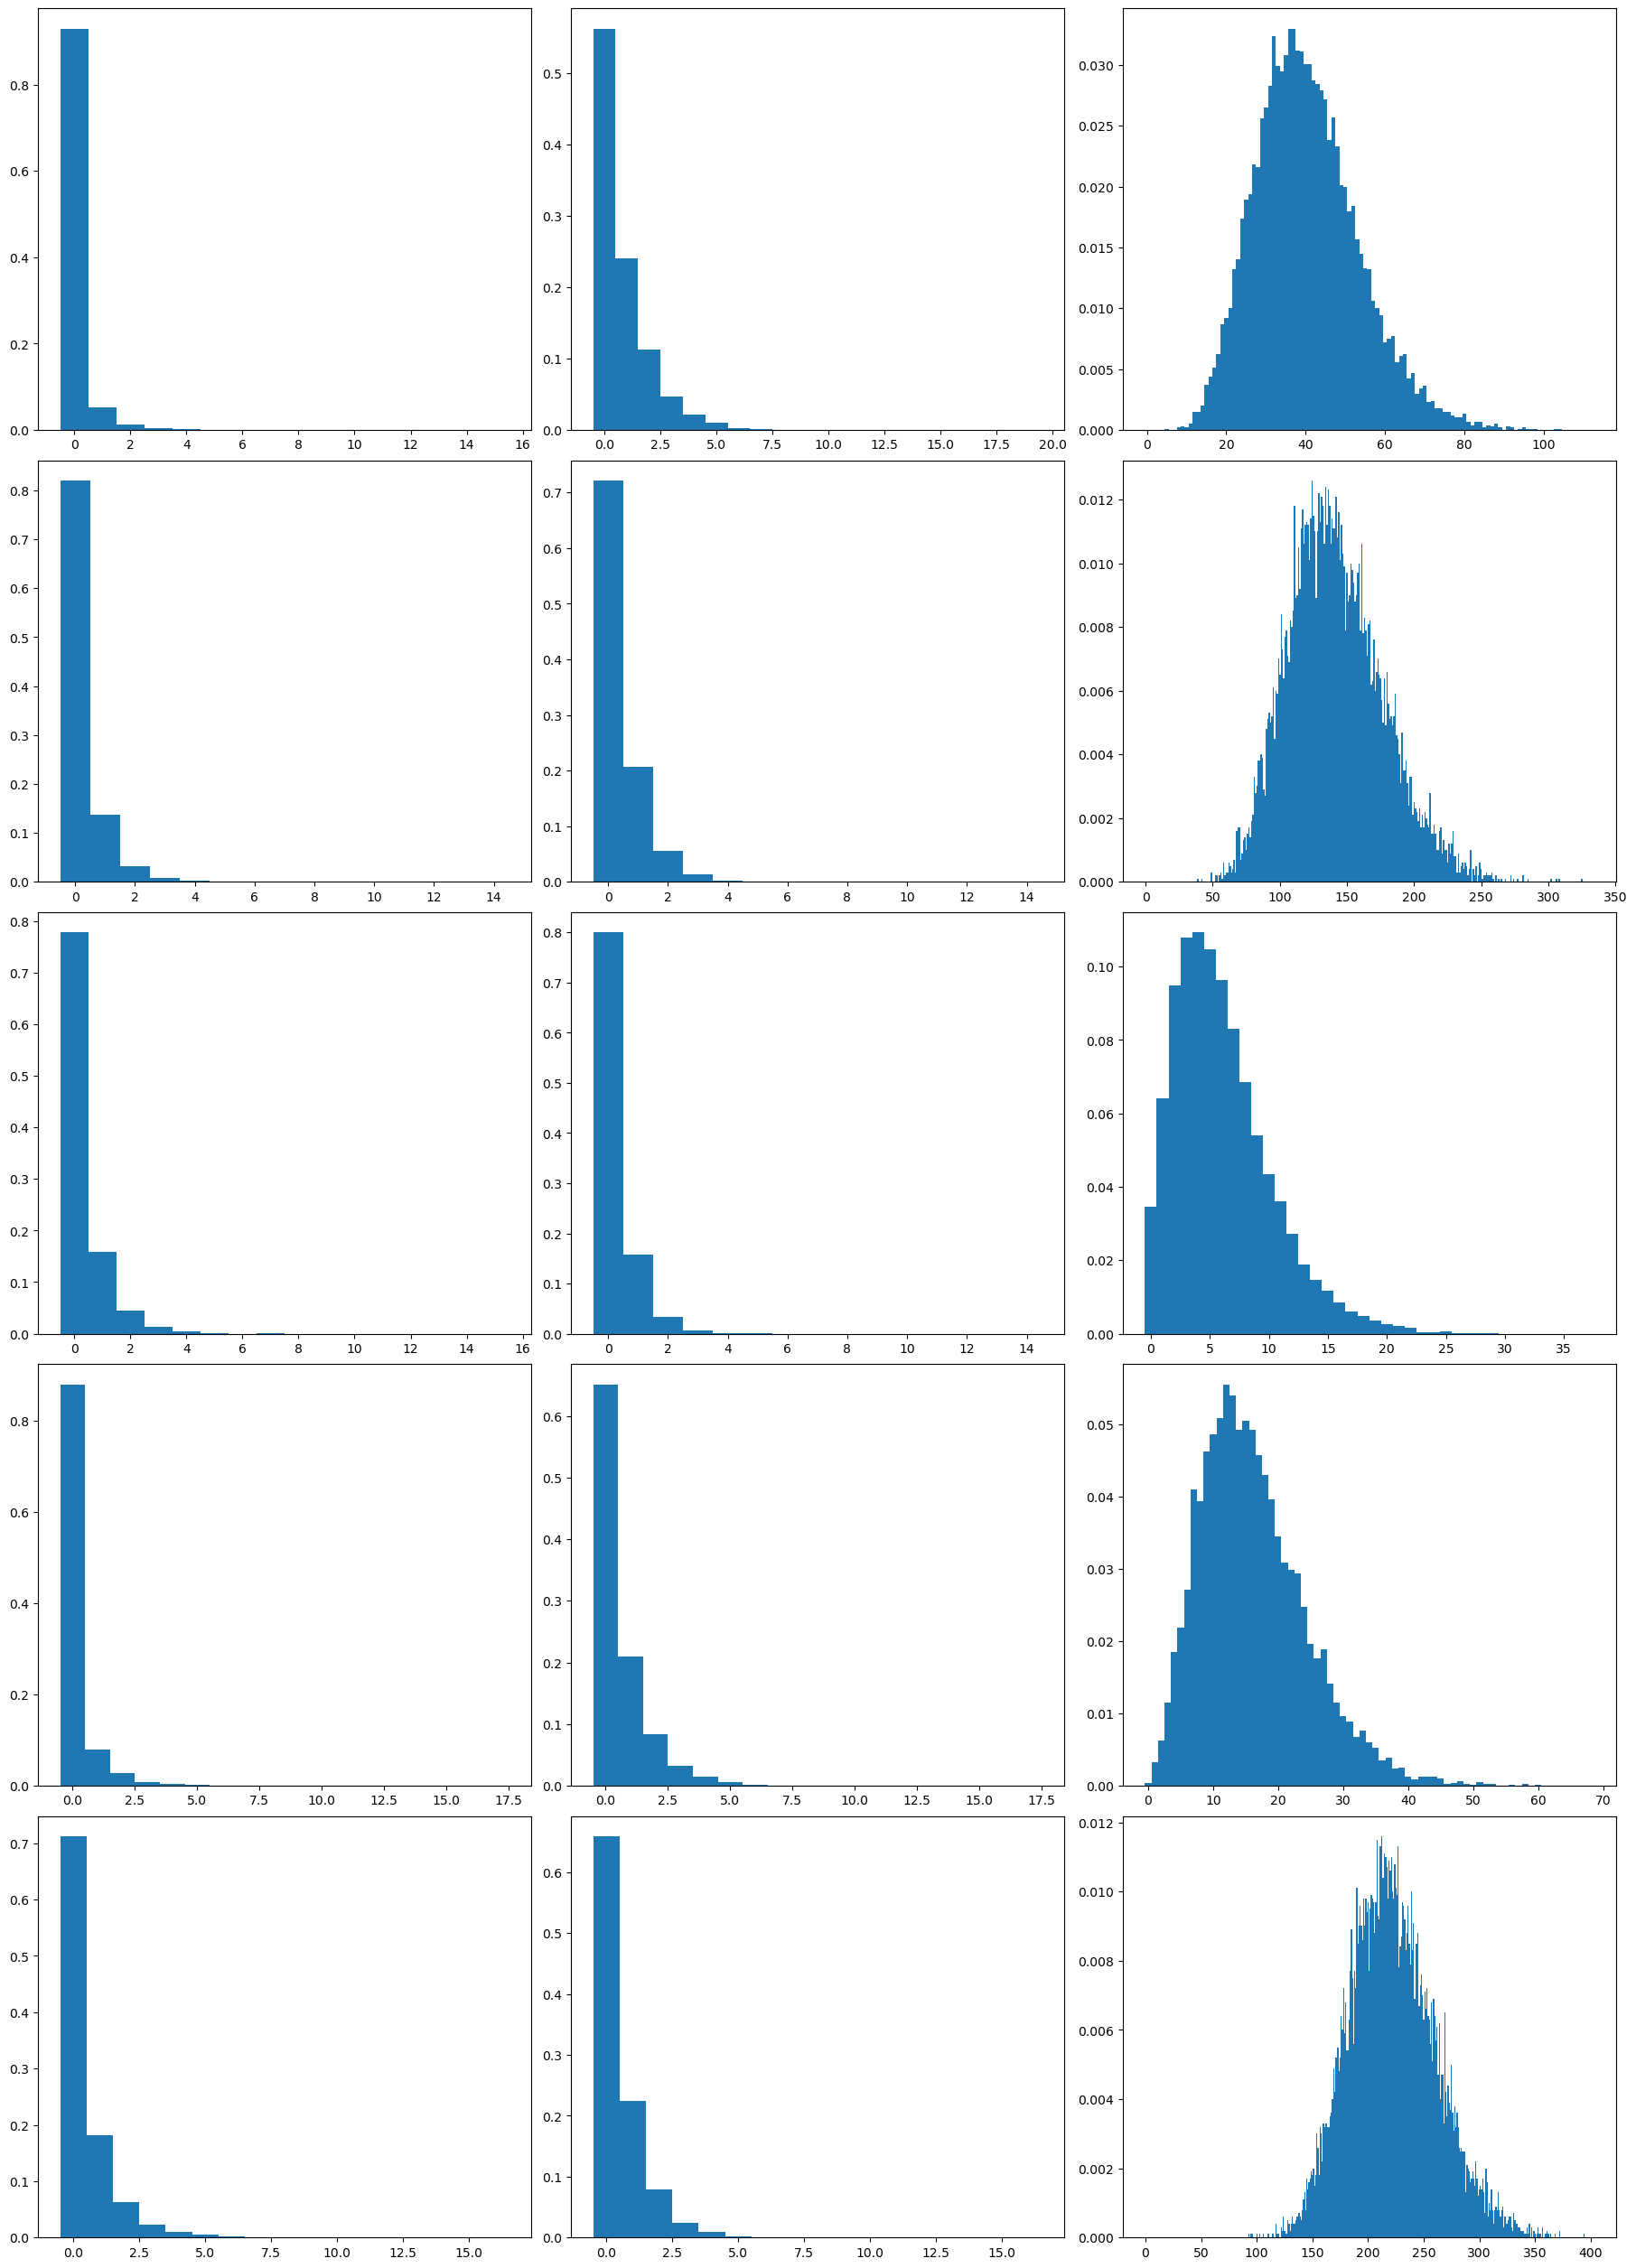

In [162]:
num_gene_plot = 5
fig, ax = plt.subplots(num_gene_plot,3,figsize=(3*6,num_gene_plot*5))

for i in range(num_gene_plot):
    ax[i,0].hist(nascent_counts[:,i],bins=np.arange(nascent_counts[:,i].max()+10)-0.5,density=True,zorder=0);
    ax[i,1].hist(mature_counts[:,i],bins=np.arange(mature_counts[:,i].max()+10)-0.5,density=True,zorder=0);
    ax[i,2].hist(protein_counts[:,i],bins=np.arange(protein_counts[:,i].max()+10)-0.5,density=True,zorder=0);

In [163]:
# Create an AnnData object
adata = ad.AnnData(mature_data)

# Add layers
adata.layers["unspliced"] = nascent_counts
adata.layers["spliced"] = mature_counts
adata.layers["protein"] = protein_counts

# Attach true_params to varm (per-gene information)
adata.varm["true_params"] = true_params

# Add var and obs
adata.var['Gene'] = np.arange(100,dtype=int)
adata.obs['Cell'] = np.arange(10000,dtype=int)

# Save to file
adata.write("./data/simulation_1.h5ad")

## Read data

In [8]:
adata = ad.read_h5ad("data/simulation_1.h5ad")
adata

AnnData object with n_obs × n_vars = 10000 × 100
    obs: 'Cell'
    var: 'Gene'
    varm: 'true_params'
    layers: 'protein', 'spliced', 'unspliced'

In [9]:
nascent_counts = adata.layers["unspliced"]
mature_counts = adata.layers["spliced"]
protein_counts = adata.layers["protein"]

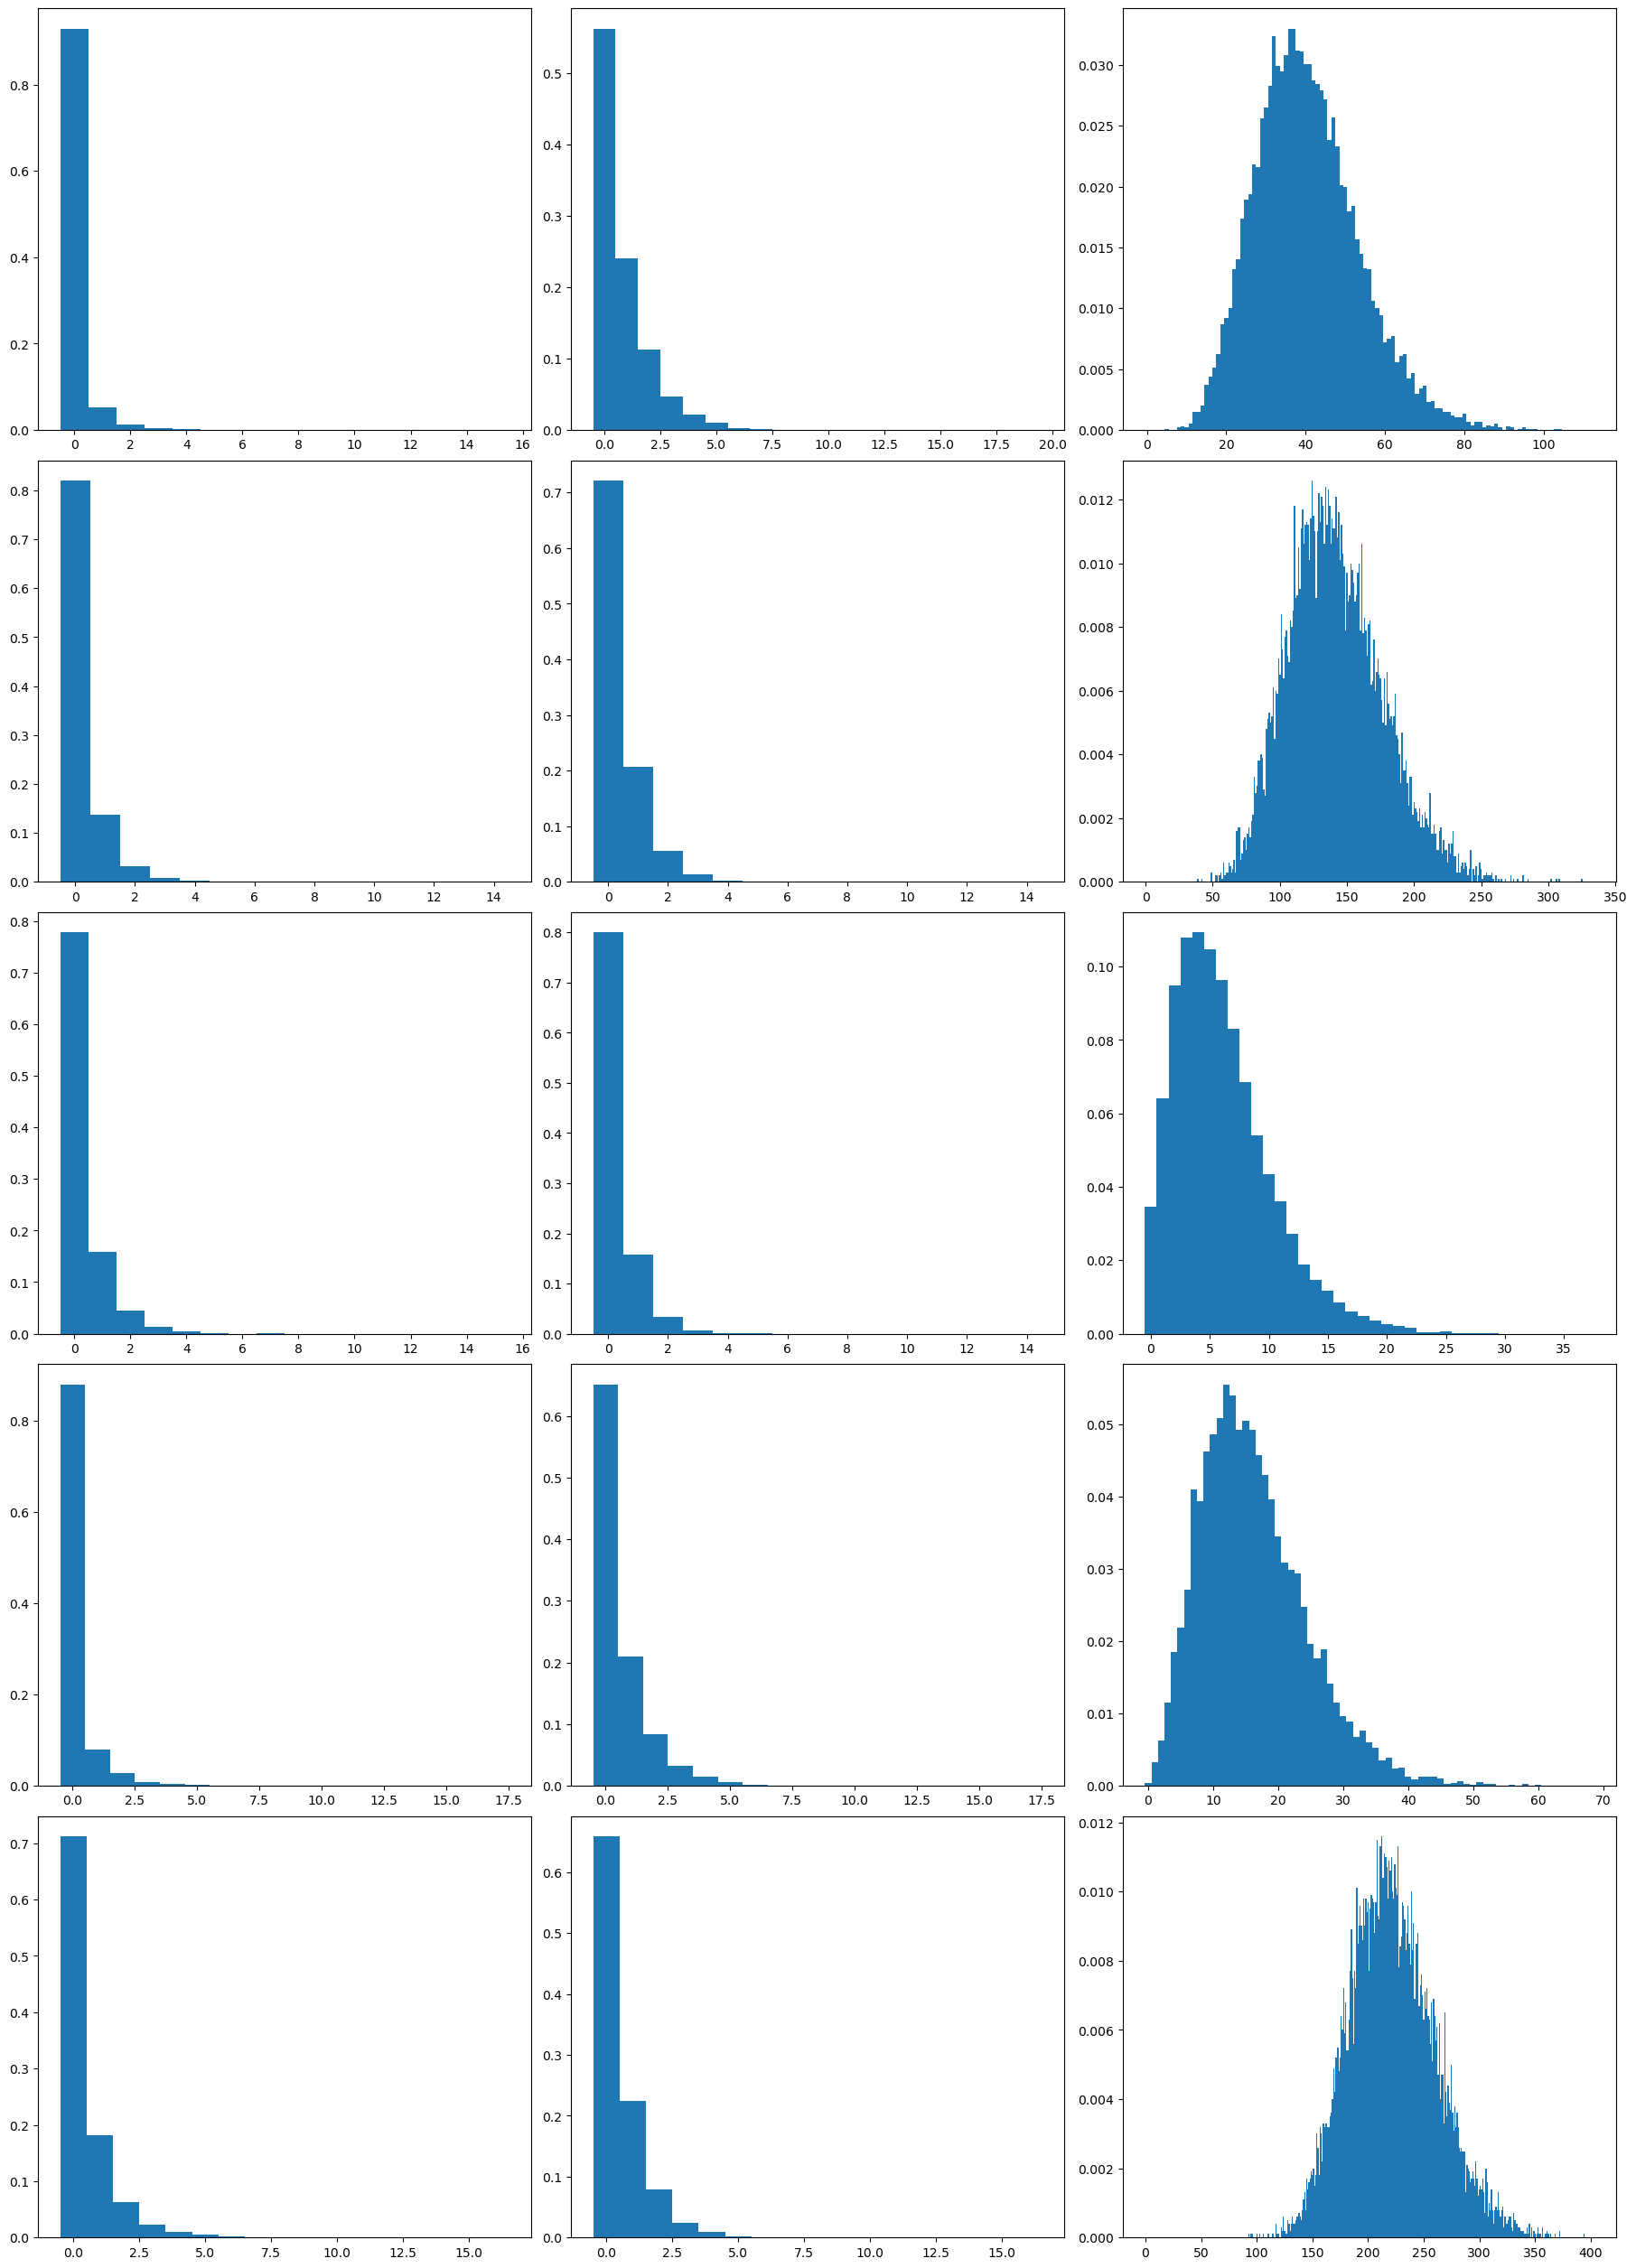

In [10]:
num_gene_plot = 5
fig, ax = plt.subplots(num_gene_plot,3,figsize=(3*6,num_gene_plot*5))

for i in range(num_gene_plot):
    ax[i,0].hist(nascent_counts[:,i],bins=np.arange(nascent_counts[:,i].max()+10)-0.5,density=True,zorder=0);
    ax[i,1].hist(mature_counts[:,i],bins=np.arange(mature_counts[:,i].max()+10)-0.5,density=True,zorder=0);
    ax[i,2].hist(protein_counts[:,i],bins=np.arange(protein_counts[:,i].max()+10)-0.5,density=True,zorder=0);

# Test monod given true sampling parameters

## Test pss function of monod

The expected modalities for this model are: ['unspliced', 'spliced', 'protein']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:Protein grid limit: inf
The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
gene 0 [ 17  21 114] time 32.376211643218994
gene 1 [ 16  16 335] time 330.3146815299988


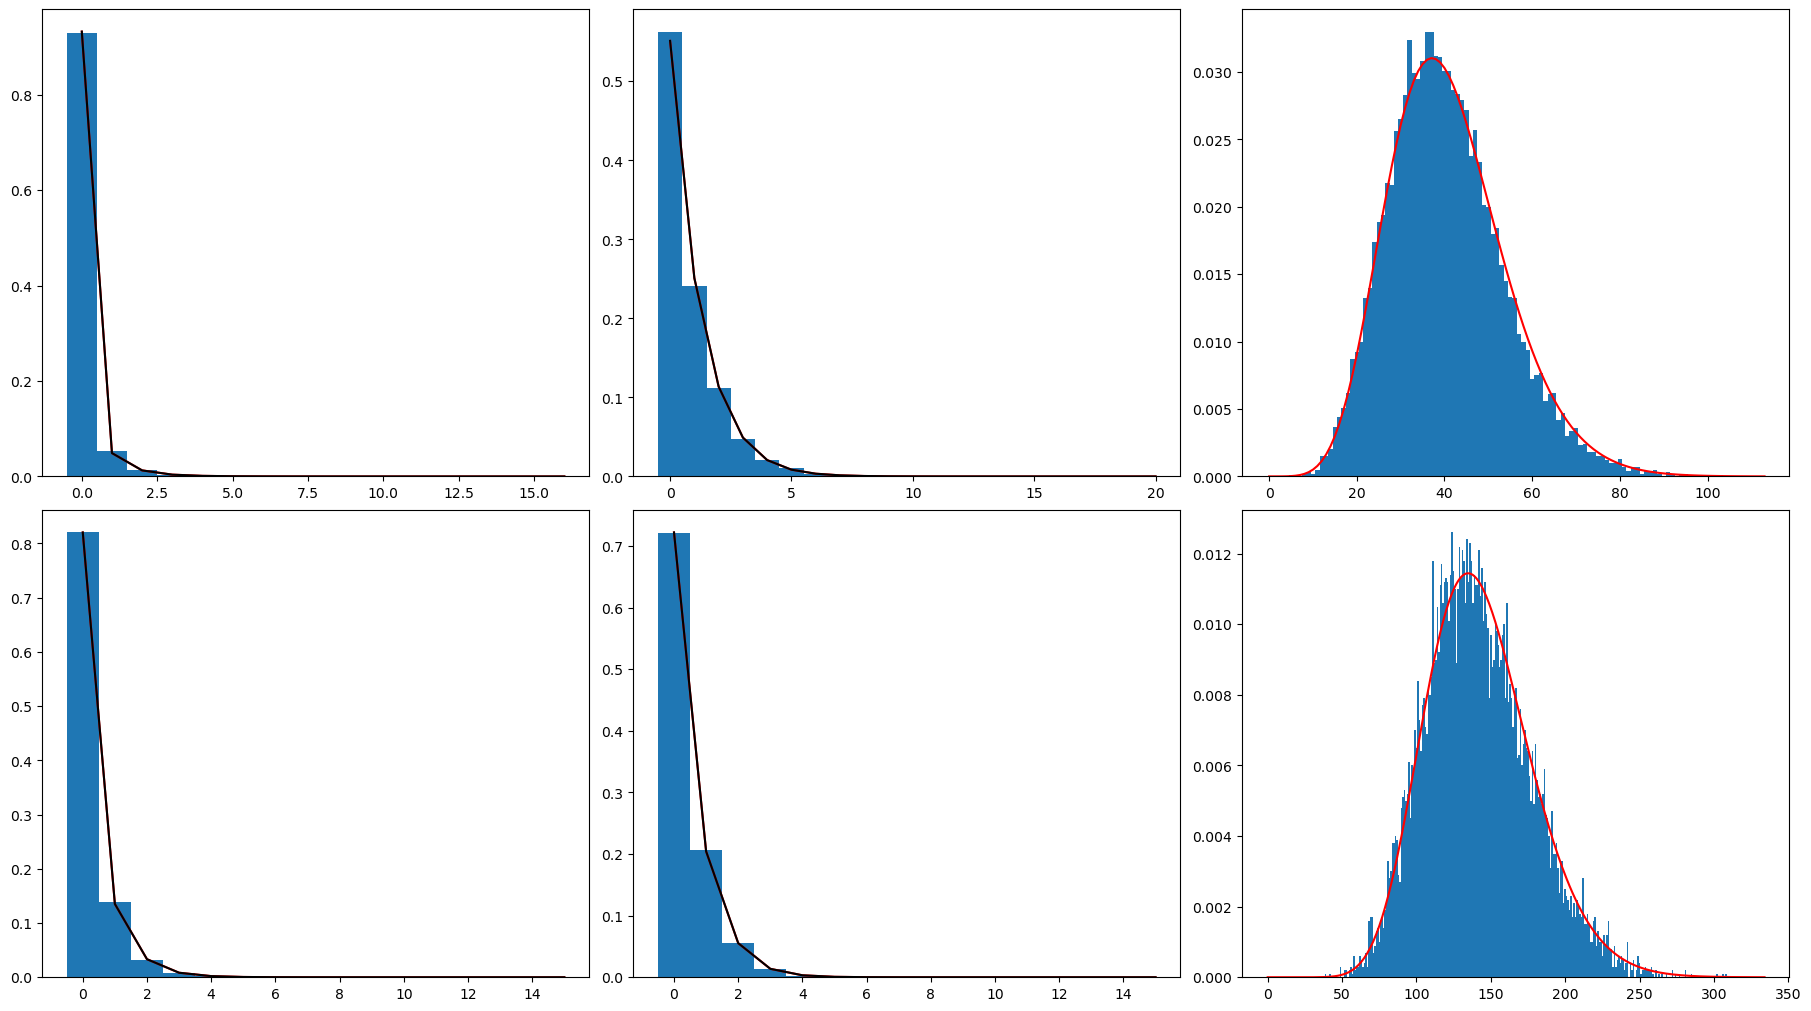

In [11]:
importlib.reload(cme_toolbox)

num_gene_plot = 2
fig, ax = plt.subplots(num_gene_plot,3,figsize=(3*6,num_gene_plot*5))
model = cme_toolbox.CMEModel('ProteinBursty','Poisson')
model_ = cme_toolbox.CMEModel('Bursty','Poisson')
ts = ti.time()
for i in range(num_gene_plot):
    p = true_params[i][:3]
    limits = np.array(np.array([nascent_counts[:,i].max(),mature_counts[:,i].max()])+10,dtype=int)
    pss_ = model_.eval_model_pss(np.log10(p), limits, samp=[-1.,-1.])
    
    p = true_params[i]
    limits = np.array(np.array([nascent_counts[:,i].max(),mature_counts[:,i].max(),protein_counts[:,i].max()])+10,dtype=int)
    pss = model.eval_model_pss(np.log10(p), limits, samp=[-1.,-1.,-1.])
    print('gene',i,limits,"time",ti.time()-ts)
    ax[i,0].plot(pss.sum(axis=(1,2)),color='r');
    ax[i,0].plot(pss_.sum(axis=(1)),color='k');
    ax[i,0].hist(nascent_counts[:,i],bins=np.arange(nascent_counts[:,i].max()+1)-0.5,density=True,zorder=0);
    ax[i,1].plot(pss.sum(axis=(0,2)),color='r');
    ax[i,1].plot(pss_.sum(axis=(0)),color='k');
    ax[i,1].hist(mature_counts[:,i],bins=np.arange(mature_counts[:,i].max()+1)-0.5,density=True,zorder=0);
    ax[i,2].plot(pss.sum(axis=(0,1)),color='r');
    ax[i,2].hist(protein_counts[:,i],bins=np.arange(protein_counts[:,i].max()+1)-0.5,density=True,zorder=0);

## Run Monod Bursty model

```
!curl https://github.com/pachterlab/monod_examples/blob/main/polyA_ref/gg_200524_mouse_genome_polyA_cum_1 -o data/polyA_ref/gg_200524_mouse_genome_polyA_cum_1
!curl https://github.com/pachterlab/monod_examples/blob/main/polyA_ref/gg_200525_genome_polyA_cum_3 -o data/polyA_ref/gg_200525_genome_polyA_cum_3
```

The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:Directory sim_fits/simulation_1_US already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: sim_fits/simulation_1_US
INFO:root:10000 cells detected.
INFO:root:100 genes detected.
46 genes retained after expression filter.
INFO:root:Number of enforced genes: 0
INFO:root:Total of 46 genes selected.
INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Lengths have not been given so are not being used
INFO:root:Directory sim_fits/simulation_1_US/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to sim_fits/simulation_1_US/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Optimizing gene

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


INFO:root:Optimized parameters for gene 0 is [2.89334428 1.22870119 0.78009817]
INFO:root:Optimizing gene 1 with initial value [[3.9262     1.256384   1.54331761]]
INFO:root:Optimized parameters for gene 1 is [3.96812312 1.27298169 1.56480187]
INFO:root:Optimizing gene 2 with initial value [[7.5603293  4.15631078 1.30778919]]
INFO:root:Optimized parameters for gene 2 is [7.66738619 4.29050881 1.32157403]
INFO:root:Optimizing gene 3 with initial value [[7.71011565 1.6390552  1.50882889]]
INFO:root:Optimized parameters for gene 3 is [7.68595212 1.63525284 1.49758928]
INFO:root:Optimizing gene 4 with initial value [[4.12554298 2.16223426 0.94018755]]
INFO:root:Optimized parameters for gene 4 is [4.12554298 2.16223426 0.94018755]
INFO:root:Optimizing gene 5 with initial value [[2.4650031  1.90937498 0.68989731]]
INFO:root:Optimized parameters for gene 5 is [2.4650031  1.90937498 0.68989731]
INFO:root:Optimizing gene 6 with initial value [[5.4497429  4.07305149 1.12365833]]
INFO:root:Optimi

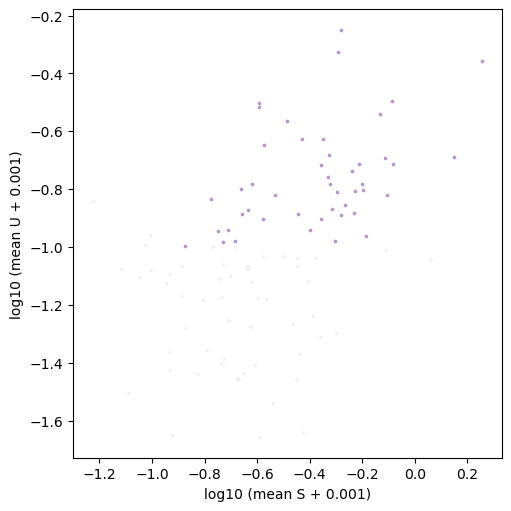

In [13]:
importlib.reload(cme_toolbox) #NM
importlib.reload(inference)

log.setLevel(logging.INFO)

fitmodel = cme_toolbox.CMEModel('Bursty','Poisson')
ts = ti.time()
adata_bursty_mom = inference.perform_inference(adata, fitmodel, dataset_string='simulation_fits/simulation_1_US',
                                   transcriptome_filepath=None, n_genes=100,
                                   filt_param={'min_means': [0.1] * 2, 'max_maxes': [100, 100], 'min_maxes': [1.0] * 2},
                                   use_lengths=False, poisson_average_log_length=0,
                                   phys_lb=[-3.]*3,phys_ub=[3.]*3,
                                   samp_lb=[-1.]*2,samp_ub=[-1.]*2,gridsize=[1,1],
                                   gradient_params={"max_iterations": 10, "init_pattern": "moments", "num_restarts": 1},
                                   hist_type='none', exclude_sigma=True, mek_means_params=None, num_cores=1)
t_running = ti.time()-ts

## Run ProteinBursty model without unspliced

In [ ]:
importlib.reload(cme_toolbox)
importlib.reload(inference)

log.setLevel(logging.INFO)

fitmodel = cme_toolbox.CMEModel('ProteinBursty','Poisson',fit_unspliced=False,min_fudge=1,max_fudge=10)
ts = ti.time()
adata_protein_mom = inference.perform_inference(adata, fitmodel, dataset_string='simulation_fits/simulation_1_SP',
                                   transcriptome_filepath=None, n_genes=100,
                                   filt_param={'min_means': [0.1] * 3, 'max_maxes': [100, 100, 1000], 'min_maxes': [1.0] * 3},
                                   use_lengths=False, poisson_average_log_length=0,
                                   phys_lb=[-3.]*5,phys_ub=[3.]*5,
                                   samp_lb=[-1.]*3,samp_ub=[-1.]*3,gridsize=[1,1,1],
                                   gradient_params={"max_iterations": 100, "init_pattern": "moments", "num_restarts": 1},
                                   hist_type='none', exclude_sigma=True, mek_means_params=None, num_cores=1)
t_running = ti.time()-ts

The expected modalities for this model are: ['unspliced', 'spliced', 'protein']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:Protein grid limit: inf
INFO:root:Directory sim_fits/simulation_1_SP created.
INFO:root:Beginning data extraction.
INFO:root:Dataset: sim_fits/simulation_1_SP
INFO:root:10000 cells detected.
INFO:root:100 genes detected.
46 genes retained after expression filter.
INFO:root:Number of enforced genes: 0
INFO:root:Total of 46 genes selected.
INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Lengths have not been given so are not being used
INFO:root:Directory sim_fits/simulation_1_SP/ProteinBursty_Poisson_1x1x1 created.
INFO:root:Global inference parameters stored to sim_fits/simulation_1_SP/ProteinBursty_Poisson_1x1x1/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


## Run full ProteinBursty model

In [ ]:
importlib.reload(cme_toolbox)
importlib.reload(inference)

log.setLevel(logging.INFO)

fitmodel = cme_toolbox.CMEModel('ProteinBursty','Poisson',fit_unspliced=True,min_fudge=1,max_fudge=10)
ts = ti.time()
adata_protein = inference.perform_inference(adata, fitmodel, dataset_string='simulation_fits/simulation_1_USP',
                                   transcriptome_filepath=None, n_genes=100,
                                   filt_param={'min_means': [0.1] * 3, 'max_maxes': [100, 100, 1000], 'min_maxes': [1.0] * 3},
                                   use_lengths=False, poisson_average_log_length=0,
                                   phys_lb=[-3.]*5,phys_ub=[3.]*5,
                                   samp_lb=[-1.]*3,samp_ub=[-1.]*3,gridsize=[1,1,1],
                                   gradient_params={"max_iterations": 100, "init_pattern": "moments", "num_restarts": 1},
                                   hist_type='none', exclude_sigma=True, mek_means_params=None, num_cores=1)
t_running = ti.time()-ts

The expected modalities for this model are: ['unspliced', 'spliced', 'protein']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:Protein grid limit: inf
INFO:root:Directory simulation_fits/simulation_1_USP created.
INFO:root:Beginning data extraction.
INFO:root:Dataset: simulation_fits/simulation_1_USP
INFO:root:10000 cells detected.
INFO:root:100 genes detected.
46 genes retained after expression filter.
INFO:root:Number of enforced genes: 0
INFO:root:Total of 46 genes selected.
INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Lengths have not been given so are not being used
INFO:root:Directory simulation_fits/simulation_1_USP/ProteinBursty_Poisson_1x1x1 created.
INFO:root:Global inference parameters stored to simulation_fits/simulation_1_USP/ProteinBursty_Poisson_1x1x1/parameters.pr.
INFO:root:Global inference paramet

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1113: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


## Check accuracy

In [55]:
adata_temp = adata_protein_mom.copy()
params_name = [
    'b',         # plain letter
    r'$\beta$',  # β
    r'$\gamma$', # γ
    r'$k_p$',    # k with subscript p
    r'$\gamma_p$' # γ with subscript p
]

fit = adata_temp.uns['search_result'].param_estimates
log_true_params = np.log10(adata_temp.varm['true_params'])

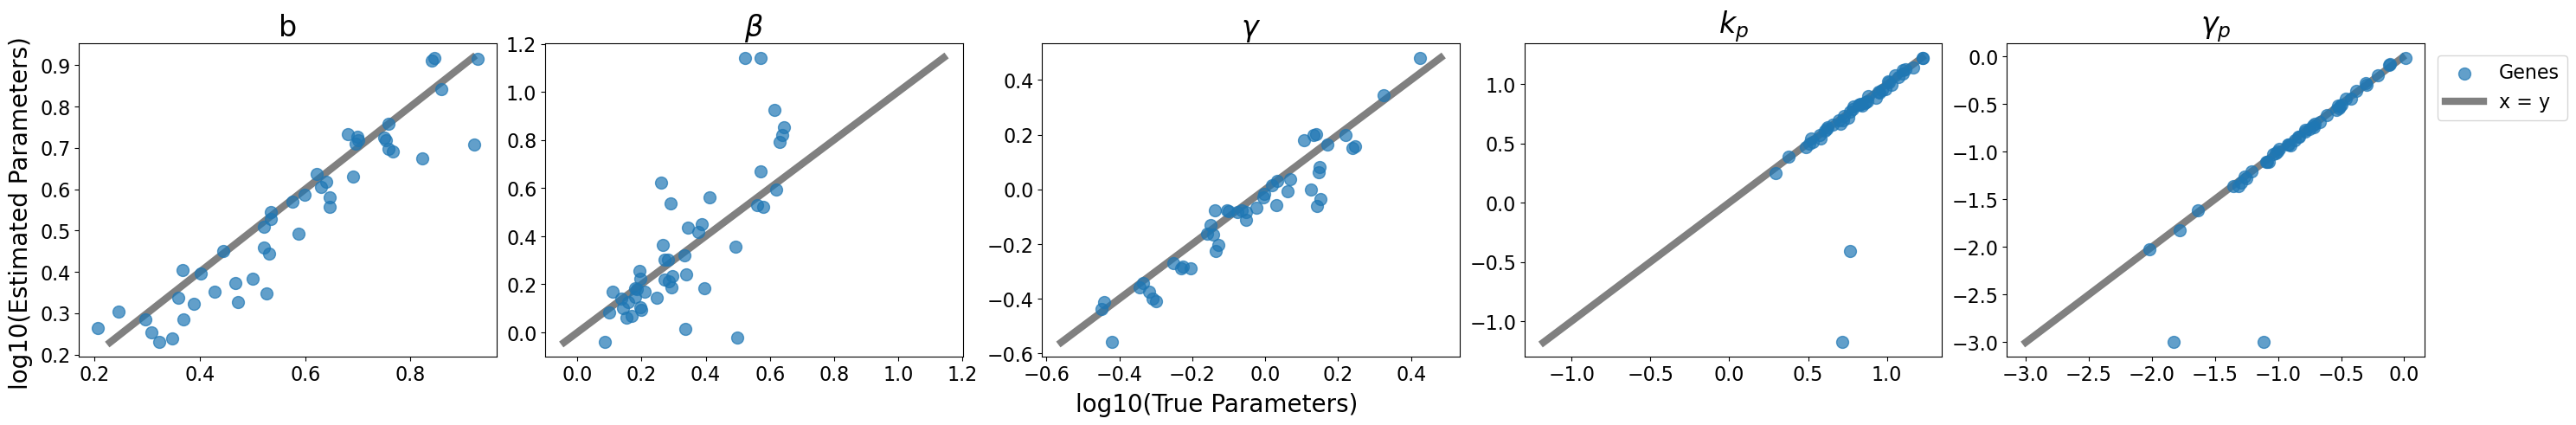

In [57]:
plt.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(1, 5, figsize=(28, 4.8))

for i, ax in enumerate(axes):
    ax.scatter(log_true_params[:, i], fit[0, :, i], alpha=0.7, s=100, label='Genes')
    x_values = np.linspace(min(fit[0, :, i]), max(fit[0, :, i]), 100)
    ax.plot(x_values, x_values, color='gray', linestyle='-', linewidth=6, label='x = y', zorder=0)
    
    ax.set_title(params_name[i],fontsize=24)
    
    # Place the legend outside to the right
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1., 0.8),fontsize=16)
fig.supxlabel("log10(True Parameters)",fontsize=20)
fig.supylabel("log10(Estimated Parameters)",fontsize=20)
plt.savefig('./simulation_fits/figures/SP.pdf',
            bbox_extra_artists=(legend,),
            bbox_inches='tight')

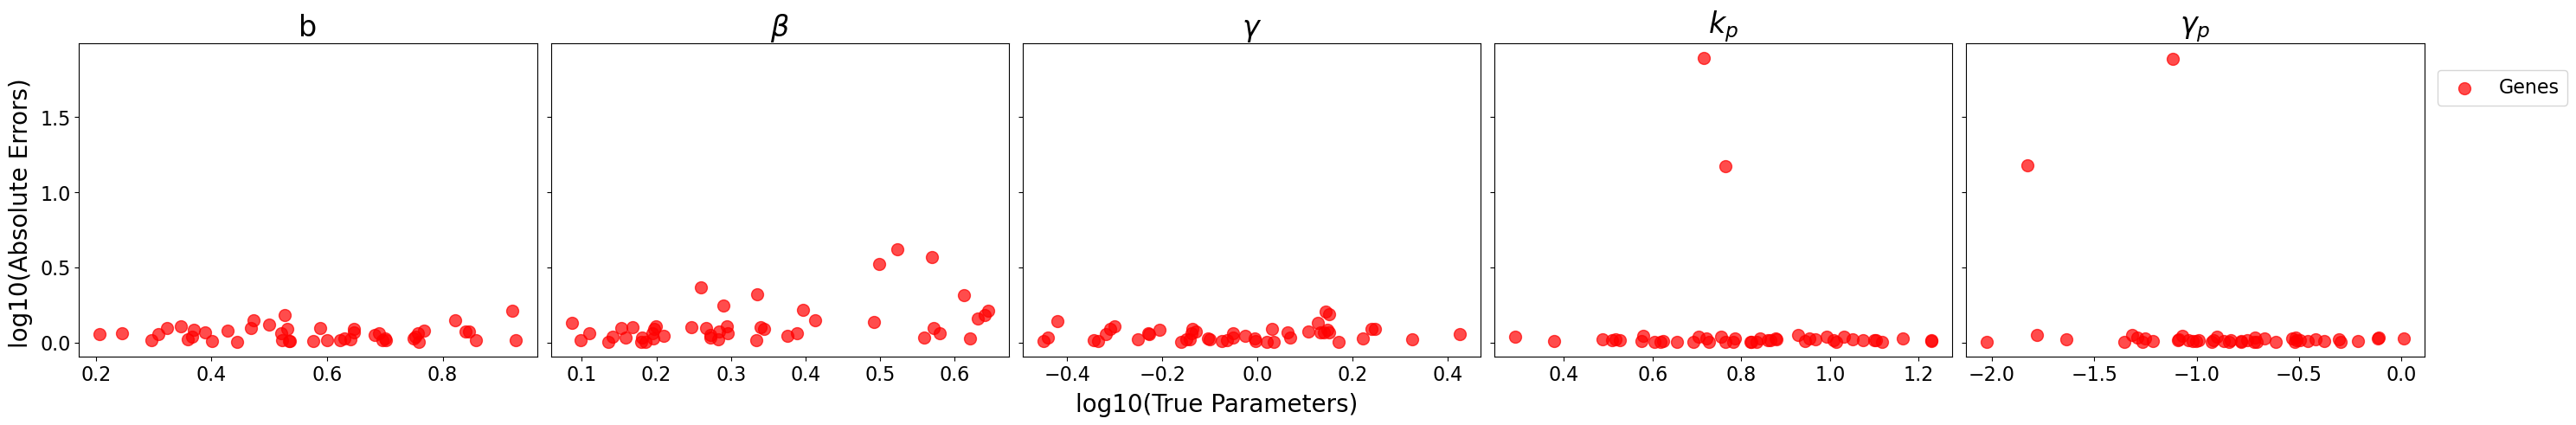

In [58]:
true_params = 10**log_true_params
fit_ = 10**fit

fig, axes = plt.subplots(1, 5, figsize=(28, 4.8), sharey=True)

for i, ax in enumerate(axes):
    ax.scatter(log_true_params[:, i], np.abs(fit[0, :, i] - log_true_params[:, i]), alpha=0.7, s=100, label='Genes', c='r')
    x_values = np.linspace(min(fit[0, :, i]), max(fit[0, :, i]), 100)    
    ax.set_title(params_name[i], fontsize=24)

# Place the legend outside to the right
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1., 0.8), fontsize=16)
fig.supxlabel("log10(True Parameters)", fontsize=20)
fig.supylabel("log10(Absolute Errors)", fontsize=20)
plt.savefig('./simulation_fits/figures/SP_error.pdf',
            bbox_extra_artists=(legend,),
            bbox_inches='tight')

In [26]:
print(t_running/3600,'hours')
adata_temp = adata_protein.copy()
params_name = [
    'b',         # plain letter
    r'$\beta$',  # β
    r'$\gamma$', # γ
    r'$k_p$',    # k with subscript p
    r'$\gamma_p$' # γ with subscript p
]

fit = adata_temp.uns['search_result'].param_estimates
log_true_params = np.log10(adata_temp.varm['true_params'])

38.53146367775069 hours


In [35]:
idx = fit[0,:,-2] < 0
fit[0,idx]

array([[ 0.69211244,  0.53668192, -0.20357928, -1.1836813 , -3.        ],
       [ 0.38122767,  0.09958124, -0.41060286, -0.40593567, -3.        ]])

In [36]:
log_true_params[idx]

array([[ 0.76713326,  0.58028143, -0.12970554,  0.71556524, -1.11583805],
       [ 0.49997542,  0.19979033, -0.30039367,  0.76479823, -1.82466277]])

In [59]:
(log_true_params[:,-2]-log_true_params[:,-1])[idx]

array([1.83140329, 2.58946099])

In [60]:
fit[0,idx,-2]-fit[0,idx,-1]

array([1.82144621, 2.59314767])

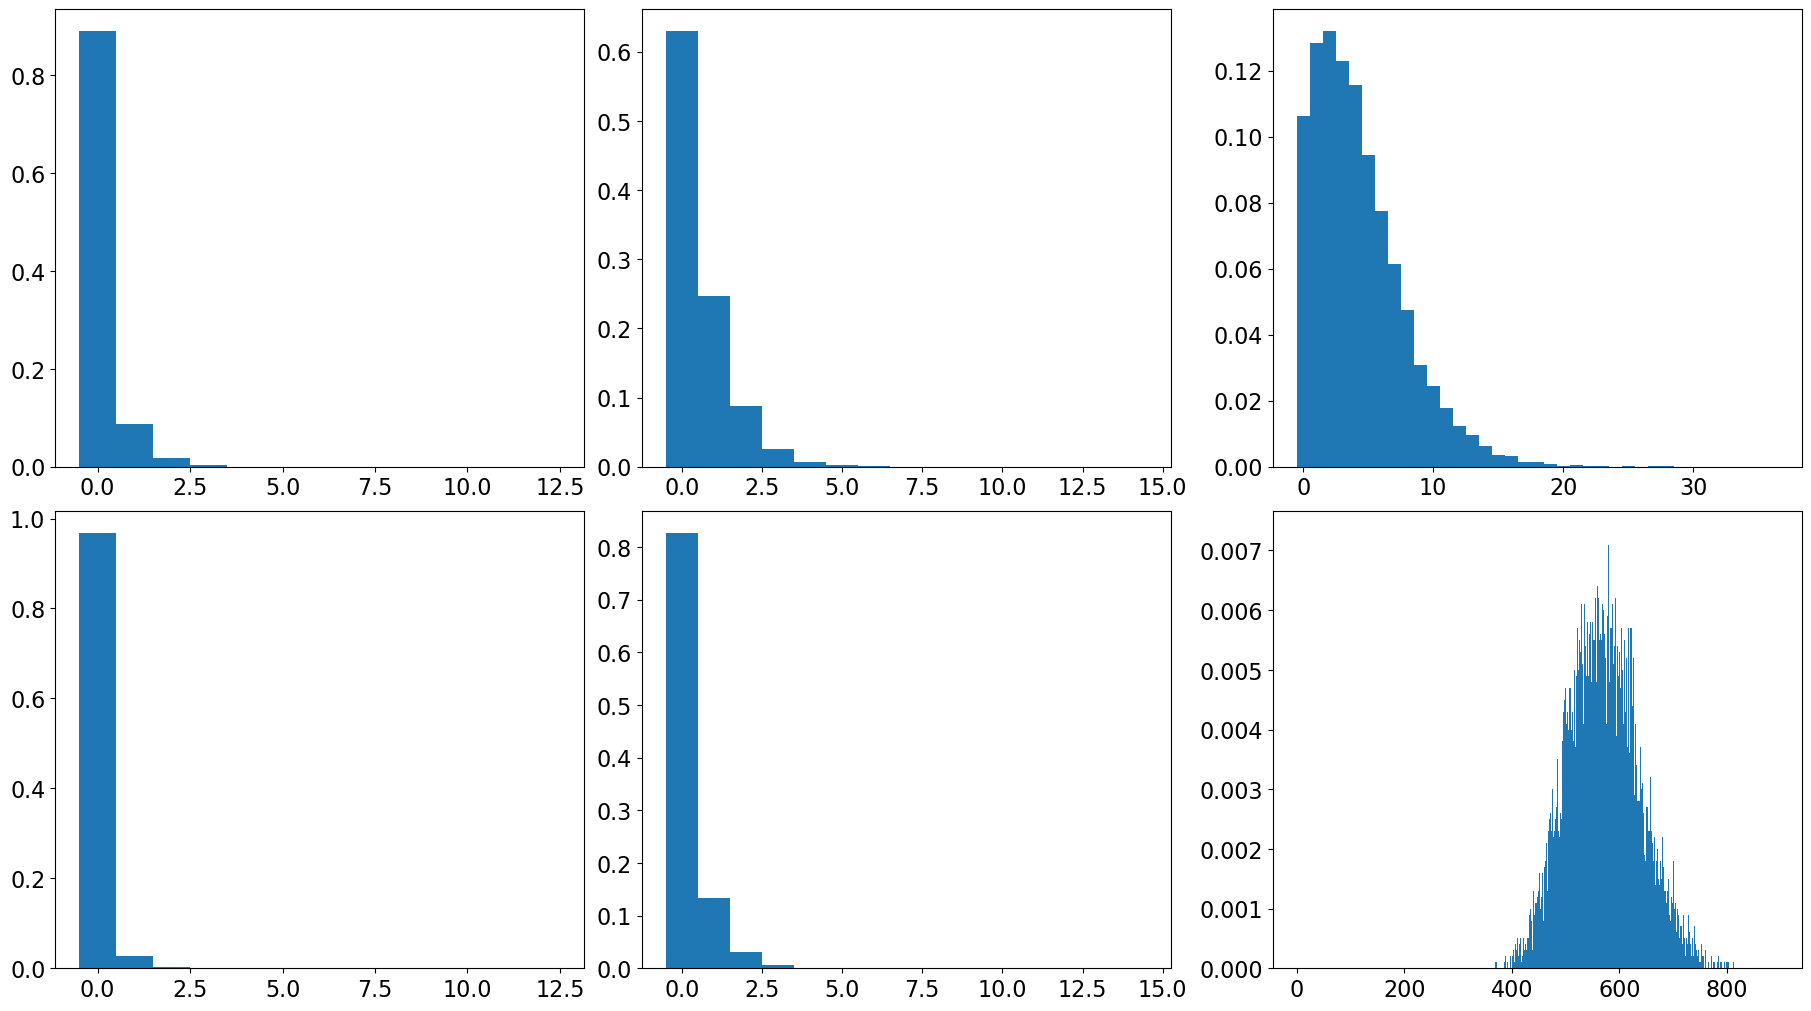

In [42]:
num_gene_plot = 2
fig, ax = plt.subplots(num_gene_plot,3,figsize=(3*6,num_gene_plot*5))

for i,j in enumerate(np.arange(46)[idx]):
    ax[i,0].hist(nascent_counts[:,j],bins=np.arange(nascent_counts[:,j].max()+10)-0.5,density=True,zorder=0);
    ax[i,1].hist(mature_counts[:,j],bins=np.arange(mature_counts[:,j].max()+10)-0.5,density=True,zorder=0);
    ax[i,2].hist(protein_counts[:,j],bins=np.arange(protein_counts[:,j].max()+10)-0.5,density=True,zorder=0);

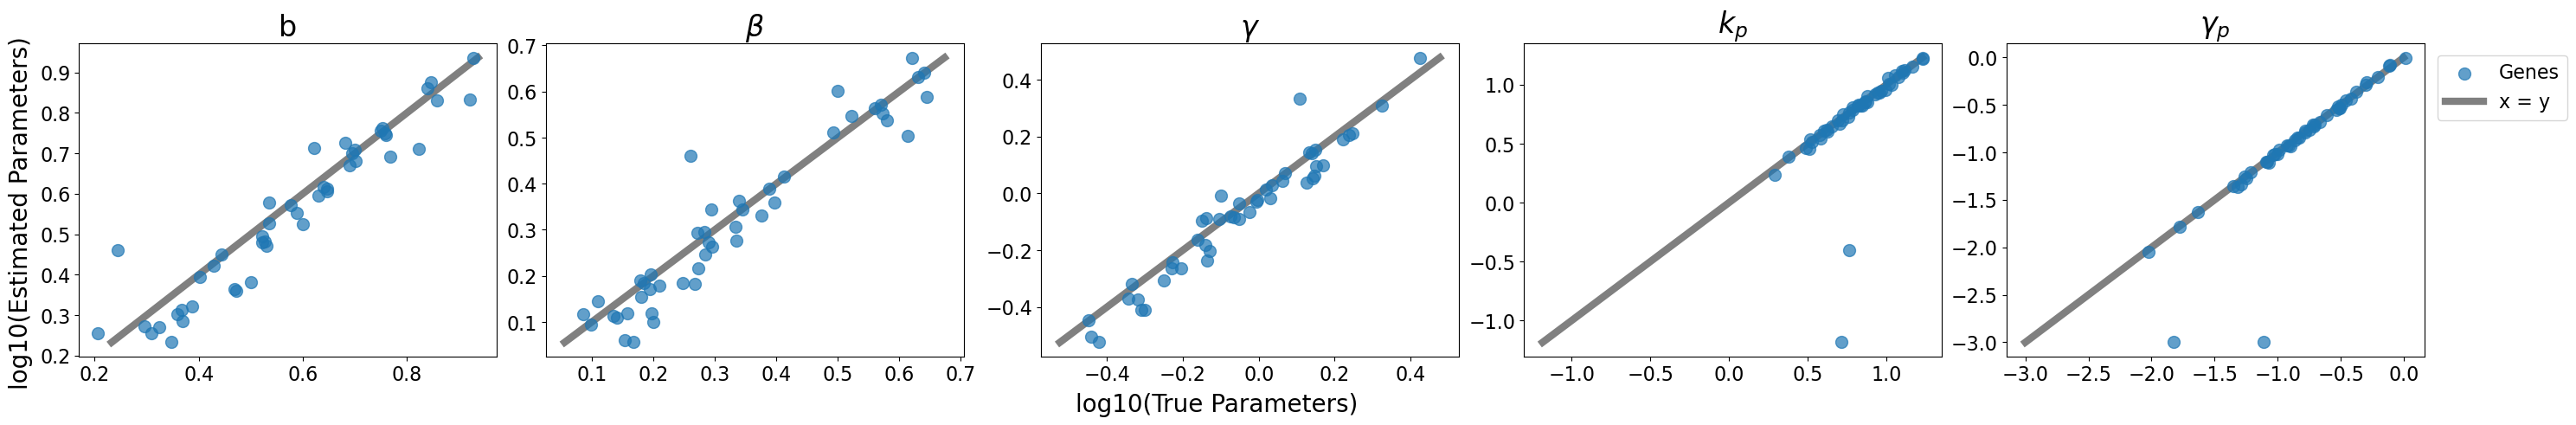

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(28, 4.8))

for i, ax in enumerate(axes):
    ax.scatter(log_true_params[:, i], fit[0, :, i], alpha=0.7, s=100, label='Genes')
    x_values = np.linspace(min(fit[0, :, i]), max(fit[0, :, i]), 100)
    ax.plot(x_values, x_values, color='gray', linestyle='-', linewidth=6, label='x = y', zorder=0)
    
    ax.set_title(params_name[i],fontsize=24)
    
    # Place the legend outside to the right
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1., 0.8),fontsize=16)
fig.supxlabel("log10(True Parameters)",fontsize=20)
fig.supylabel("log10(Estimated Parameters)",fontsize=20)
plt.savefig('./simulation_fits/figures/USP.pdf',
            bbox_extra_artists=(legend,),
            bbox_inches='tight')

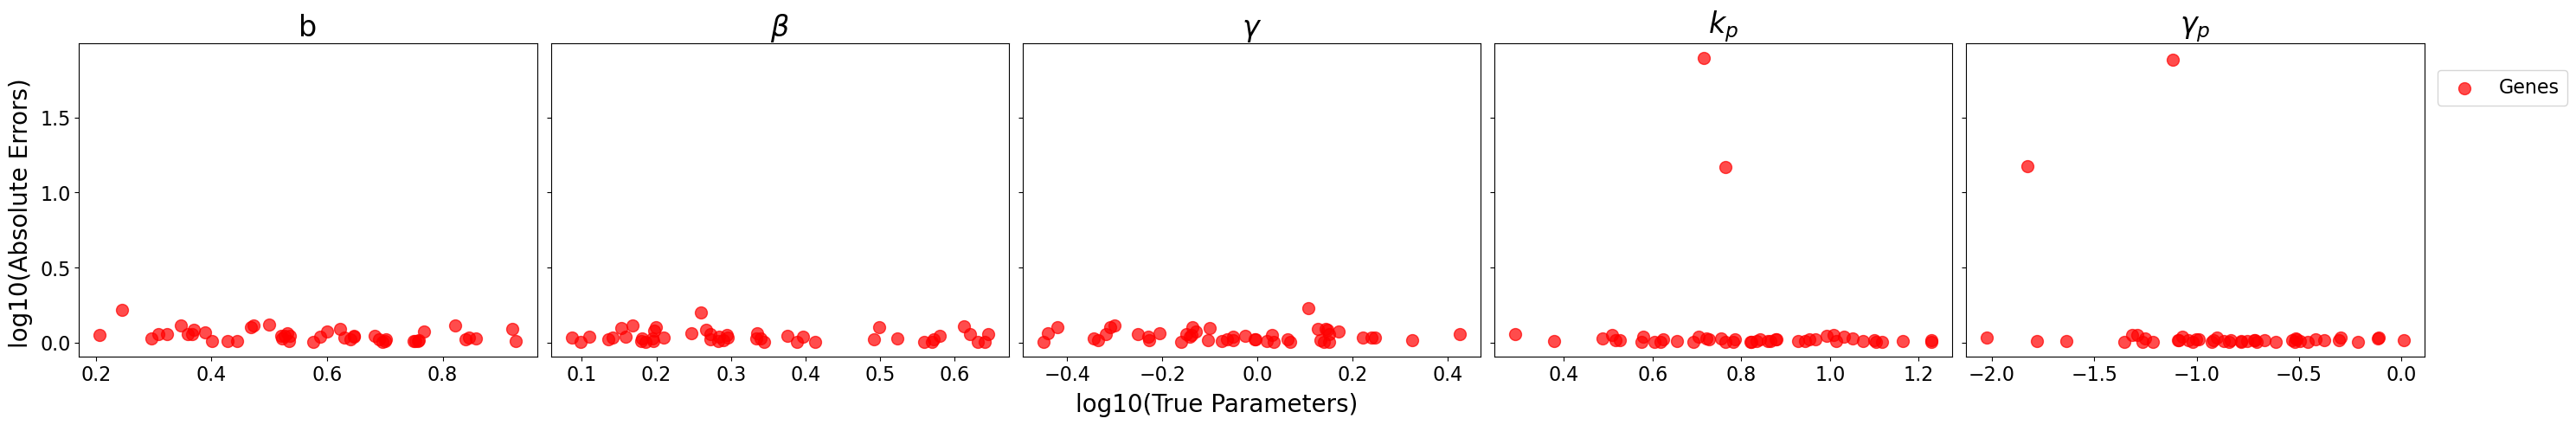

In [46]:
true_params = 10**log_true_params
fit_ = 10**fit

fig, axes = plt.subplots(1, 5, figsize=(28, 4.8), sharey=True)

for i, ax in enumerate(axes):
    ax.scatter(log_true_params[:, i], np.abs(fit[0, :, i] - log_true_params[:, i]), alpha=0.7, s=100, label='Genes', c='r')
    x_values = np.linspace(min(fit[0, :, i]), max(fit[0, :, i]), 100)    
    ax.set_title(params_name[i], fontsize=24)

# Place the legend outside to the right
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1., 0.8), fontsize=16)
fig.supxlabel("log10(True Parameters)", fontsize=20)
fig.supylabel("log10(Absolute Errors)", fontsize=20)
plt.savefig('./simulation_fits/figures/USP_error.pdf',
            bbox_extra_artists=(legend,),
            bbox_inches='tight')

In [40]:
print(adata_temp.uns['search_result'].__dict__.keys())

dict_keys(['sp', 'inference_string', 'model', 'n_genes', 'n_cells', 'gene_names', 'param_estimates', 'klds', 'obj_func', 'd_time', 'regressor', 'analysis_figure_string', 'full_result_string', 'samp_optimum_ind', 'samp_optimum', 'phys_optimum', 'regressor_optimum'])


In [41]:
adata_temp.var

,Gene,gene_exp_filter,selected_genes,MOM_unspliced_mean,MOM_unspliced_var,MOM_spliced_mean,MOM_spliced_var,MOM_protein_mean,MOM_protein_var,MOM_cov_unspliced_spliced,MOM_cov_unspliced_protein,MOM_cov_spliced_protein,$b$,$\beta$,$\gamma$,$k_p$,$\gamma_p$,AIC
1,1,True,True,0.2353,0.326534,0.3712,0.472411,141.3513,1261.698688,0.040261,0.670906,2.246222,0.487593,0.115408,-0.079297,1.230786,-1.352483,NaN
2,2,True,True,0.3125,0.466444,0.2544,0.328481,6.0831,17.020394,0.056506,0.179149,0.400299,0.591381,0.099574,0.184046,0.823201,-0.553591,NaN
3,3,True,True,0.1819,0.337612,0.5781,0.996300,16.1491,66.043869,0.095253,0.052884,1.761581,0.748629,0.516896,-0.029799,0.690087,-0.739121,NaN
4,4,True,True,0.4704,0.880124,0.5110,0.746679,221.9541,1541.764993,0.188444,1.012493,2.700425,0.905986,0.226390,0.198853,1.013465,-1.625481,NaN
6,6,True,True,0.1908,0.288595,0.4388,0.617055,5.3636,13.516795,0.052282,0.066232,0.614214,0.611348,0.328959,-0.031512,0.545094,-0.541454,NaN
7,7,True,True,0.1291,0.173833,0.3573,0.460237,9.4241,24.853039,0.020975,0.041053,0.584027,0.389234,0.280436,-0.163832,0.574554,-0.846800,NaN
11,11,True,True,0.1338,0.220098,0.4850,0.756175,19.9325,131.987544,0.069514,0.191551,2.779115,0.765199,0.636357,0.076061,1.085816,-0.524572,NaN
12,12,True,True,0.2243,0.330590,0.2647,0.356434,11.2824,26.792450,0.056433,0.048863,0.373786,0.531188,0.181829,0.108094,0.610519,-1.018469,NaN
14,14,True,True,0.1387,0.189862,0.5415,0.721278,4.2709,12.218913,0.034897,0.064733,0.956303,0.469627,0.327334,-0.264251,0.805319,-0.091745,NaN
16,16,True,True,0.1303,0.214122,0.5848,0.928609,21.1732,108.466802,0.057706,0.058038,2.378150,0.735977,0.627597,-0.031810,0.848846,-0.709478,NaN
